In [1]:
import pandas as pd
from sklearn.linear_model import LinearRegression

In [2]:
data = pd.read_csv("../../data/data1.csv")
data

,年齢,性別,介入,売り上げ
0,26,0,0,7920
1,67,1,1,7070
2,41,0,1,9230
3,46,1,1,9490
4,45,0,0,8490
...,...,...,...,...
995,23,1,0,9480
996,49,1,1,8520
997,28,1,1,10150
998,50,1,0,7840


In [3]:
data["性別"].value_counts()

性別
1    708
0    292
Name: count, dtype: int64

In [4]:
data["介入"].value_counts()

介入
0    673
1    327
Name: count, dtype: int64

<Axes: >

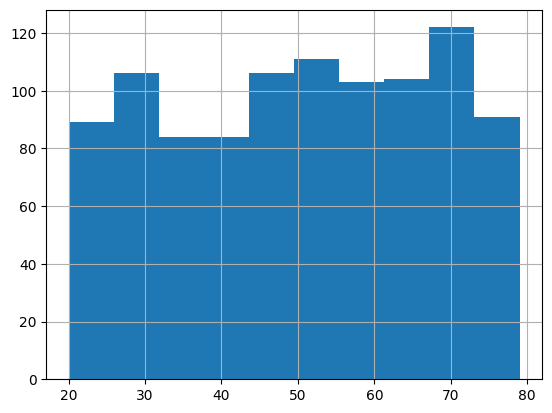

In [5]:
data["年齢"].hist()

<Axes: >

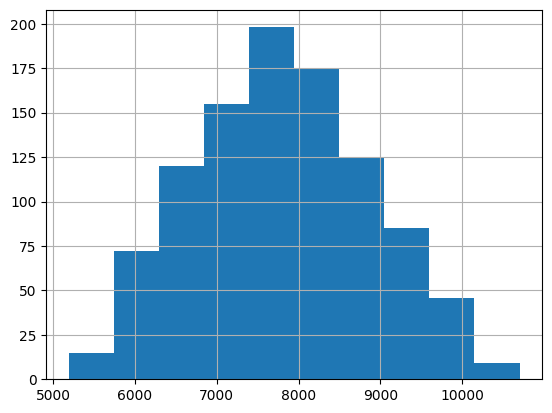

In [6]:
data["売り上げ"].hist()

In [7]:
# ダメな例
data.query("介入 == 1")["売り上げ"].mean()

np.float64(8266.941896024466)

In [8]:
data.query("介入 == 0")["売り上げ"].mean()

np.float64(7565.794947994056)

In [9]:
X = data[["介入", "性別", "年齢"]]
Y = data["売り上げ"]

In [10]:
X

,介入,性別,年齢
0,0,0,26
1,1,1,67
2,1,0,41
3,1,1,46
4,0,0,45
...,...,...,...
995,0,1,23
996,1,1,49
997,1,1,28
998,0,1,50


In [11]:
Y

0       7920
1       7070
2       9230
3       9490
4       8490
       ...  
995     9480
996     8520
997    10150
998     7840
999     7930
Name: 売り上げ, Length: 1000, dtype: int64

In [12]:
model = LinearRegression()
model.fit(X, Y)

LinearRegression()

In [13]:
coef = model.coef_
intercept = model.intercept_

In [14]:
print("coef:", coef)
print("intercept:", intercept)

coef: [551.97818728 220.34868887 -49.32467802]
intercept: 9943.64218910539


## 逆確率重み付け法（IPW）

In [15]:
import pandas as pd
from sklearn.linear_model import LogisticRegression

In [16]:
data = pd.read_csv("../../data/data1.csv")
data

,年齢,性別,介入,売り上げ
0,26,0,0,7920
1,67,1,1,7070
2,41,0,1,9230
3,46,1,1,9490
4,45,0,0,8490
...,...,...,...,...
995,23,1,0,9480
996,49,1,1,8520
997,28,1,1,10150
998,50,1,0,7840


In [17]:
X = data[["介入", "性別", "年齢"]]
Y = data["売り上げ"]

In [18]:
def cal_propensity_scores(X, Z):
    model = LogisticRegression().fit(X, Z)
    propensity_score = model.predict_proba(X)
    return propensity_score

In [19]:
Z = X["介入"]
X = X.drop(columns="介入")

In [20]:
propensity_score = cal_propensity_scores(X, Z)
propensity_score

array([[0.62097409, 0.37902591],
       [0.70894011, 0.29105989],
       [0.65625774, 0.34374226],
       ...,
       [0.62069582, 0.37930418],
       [0.67191706, 0.32808294],
       [0.63262505, 0.36737495]])

In [21]:
ate_i = Y / propensity_score[:, 1] * Z - Y / propensity_score[:, 0] * (1 - Z)
ate = ate_i.sum() / len(Y)

In [22]:
print("ATE:", ate)

ATE: 548.8254877221941


In [23]:
import dowhy

data = pd.read_csv("../../data/data1.csv")
model = dowhy.CausalModel(
    data=data,
    treatment="介入",
    outcome="売り上げ",
    common_causes=["性別", "年齢"],
)

In [24]:
identified_estimand = model.identify_effect()
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                 
─────(E[売り上げ|性別,年齢])
d[介入]               
Estimand assumption 1, Unconfoundedness: If U→{介入} and U→売り上げ then P(売り上げ|介入,性別,年齢,U) = P(売り上げ|介入,性別,年齢)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In [25]:
estimate = model.estimate_effect(
    identified_estimand,
    method_name="backdoor.propensity_score_matching",
)
print(estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                 
─────(E[売り上げ|性別,年齢])
d[介入]               
Estimand assumption 1, Unconfoundedness: If U→{介入} and U→売り上げ then P(売り上げ|介入,性別,年齢,U) = P(売り上げ|介入,性別,年齢)

## Realized estimand
b: 売り上げ~介入+性別+年齢
Target units: ate

## Estimate
Mean value: 534.0



In [26]:
refutation = model.refute_estimate(
    identified_estimand,
    estimate,
    method_name="placebo_treatment_refuter",
)

print(refutation)

Refute: Use a Placebo Treatment
Estimated effect:534.0
New effect:11.466299999999999
p value:0.98



## 回帰不連続

In [27]:
import matplotlib.pyplot as plt
import pandas as pd

In [28]:
data = pd.read_csv("../../data/data2.csv")
data

,前回テスト点数,補講フラグ,今回テスト点数
0,78,0,72
1,97,0,100
2,69,1,82
3,56,1,55
4,74,0,84
...,...,...,...
195,78,0,70
196,81,0,78
197,72,0,73
198,80,0,84


In [29]:
# 補講なし
intervention0 = data[data["補講フラグ"] == 0]
x0 = intervention0["前回テスト点数"]
y0 = intervention0["今回テスト点数"]

In [30]:
# 補講あり
intervention1 = data[data["補講フラグ"] == 1]
x1 = intervention1["前回テスト点数"]
y1 = intervention1["今回テスト点数"]

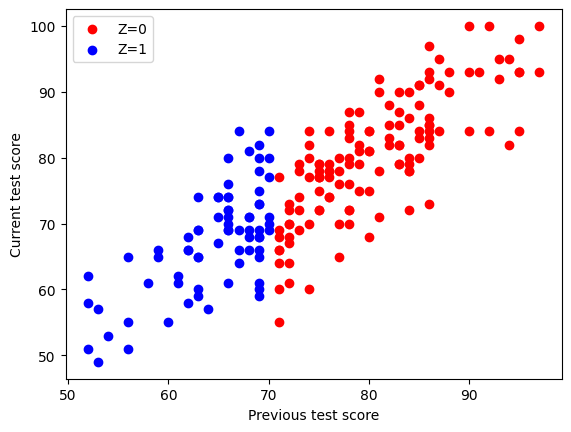

In [31]:
plt.scatter(x0, y0, c="red", label="Z=0")
plt.scatter(x1, y1, c="blue", label="Z=1")

plt.xlabel("Previous test score")
plt.ylabel("Current test score")

plt.legend()
plt.show()

In [32]:
import pandas as pd
from sklearn.linear_model import LinearRegression

In [33]:
data = pd.read_csv("../../data/data2.csv")
data

,前回テスト点数,補講フラグ,今回テスト点数
0,78,0,72
1,97,0,100
2,69,1,82
3,56,1,55
4,74,0,84
...,...,...,...
195,78,0,70
196,81,0,78
197,72,0,73
198,80,0,84


In [34]:
X = data[["前回テスト点数", "補講フラグ"]]
Y = data["今回テスト点数"]

In [35]:
model = LinearRegression()
model.fit(X, Y)

LinearRegression()

In [36]:
model.coef_

array([1.05469672, 4.15834521])